In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import random
import time

import matplotlib.pyplot as plt

import numpy as np

In [104]:
import constants
import os
import sys

In [105]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [106]:
data_dir = constants.RAW_DATA_PATH + '/'

transformations = transforms.Compose([
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [107]:
data = datasets.ImageFolder(data_dir, transform = transformations)

# test_data = datasets.ImageFolder(data_dir, transform = transformations)

In [108]:
# test_size = 0.2
# num_train = len(train_data)
# indices = list(range(num_train))
# split = int(np.floor(valid_size * num_train))
# np.random.shuffle(indices)

In [109]:
# from torch.utils.data.sampler import SubsetRandomSampler

# train_idx, test_idx = indices[split:], indices[:split]
# train_sampler = SubsetRandomSampler(train_idx)
# test_sampler = SubsetRandomSampler(test_idx)
# trainloader = torch.utils.data.DataLoader(train_data,
#                sampler=train_sampler, batch_size=64)
# testloader = torch.utils.data.DataLoader(test_data,
#                sampler=test_sampler, batch_size=64)

In [110]:
n_train_and_valid_examples = int(len(data)*0.85)
n_test_examples = len(data) - n_train_and_valid_examples

train_and_valid_data, test_data = torch.utils.data.random_split(data, 
                                                       [n_train_and_valid_examples, n_test_examples])

n_train_exmaples = int(len(train_and_valid_data)*0.70)
n_valid_examples = len(train_and_valid_data) - n_train_exmaples

train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, 
                                                       [n_train_exmaples, n_valid_examples])

In [111]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4252
Number of validation examples: 1823
Number of testing examples: 1073


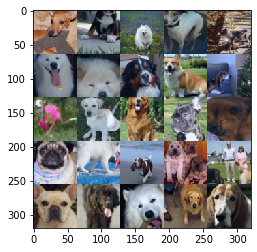

In [113]:
n_imgs = 25

batch = torch.zeros(n_imgs, 3, 64, 64)

for i in range(n_imgs):
    img, _ = train_data[i]
    batch[i] = img
        
grid_img = torchvision.utils.make_grid(batch, 
                                       nrow = 5,
                                       padding = 0,
                                       normalize = True)

plt.imshow(grid_img.permute(1, 2, 0))

In [114]:
BATCH_SIZE = 16

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size = BATCH_SIZE)

In [115]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, output_dim):
        super().__init__()
        
        assert len(hid_dims) > 0
        
        self.input_fc = nn.Linear(input_dim, hid_dims[0])
        
        self.fcs = nn.ModuleList([nn.Linear(hid_dims[i], hid_dims[i+1]) 
                                  for i in range(len(hid_dims)-1)])
        
        self.output_fc = nn.Linear(hid_dims[-1], output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        x = x.view(x.shape[0], -1)
        
        #x = [batch size, height * width]
        
        x = F.relu(self.input_fc(x))
        
        #x = [batch size, hid dims[0]]
        
        for fc in self.fcs:
            x = F.relu(fc(x))
        
        #x = [batch size, hid dims[-1]]
        
        x = self.output_fc(x)
        
        #x = [batch size, output dim]
        
        return x

In [116]:
INPUT_DIM = 64 * 64 * 3
HID_DIMS = [1000, 500, 250]
OUTPUT_DIM = 7

model = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

In [117]:
model

MLP(
  (input_fc): Linear(in_features=12288, out_features=1000, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
  )
  (output_fc): Linear(in_features=250, out_features=7, bias=True)
)

In [118]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,916,507 trainable parameters


In [119]:
optimizer = optim.Adam(model.parameters())

In [120]:
criterion = nn.CrossEntropyLoss()

In [121]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [122]:
model = model.to(device)
criterion = criterion.to(device)

In [123]:
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [124]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [125]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [126]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 34s
	Train Loss: 1.877 | Train Acc: 28.38%
	 Val. Loss: 1.811 |  Val. Acc: 31.81%
Epoch: 02 | Epoch Time: 2m 37s
	Train Loss: 1.789 | Train Acc: 31.49%
	 Val. Loss: 1.781 |  Val. Acc: 30.55%
Epoch: 03 | Epoch Time: 2m 34s
	Train Loss: 1.716 | Train Acc: 32.42%
	 Val. Loss: 1.808 |  Val. Acc: 31.31%


In [23]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.074 | Test Acc: 97.99%
